### Consensus model using following algorithm

Online aggregation method for bounding box class labels

1. Collect bounding box labels with associated class and labeler
2. For each image and class, maintain an array of values from [0-1] which has the same dimensions and the original image
3. For each bounding box label, iterate over the corresponding values captured in the array and update the probabilities in the following manner:
    a. Assume independence between current values and new label
    b. Use the labellers ‘class expertise rating’ [0,1]to Calculate the likelihood of the current label AND the new label to be incorrect
    c. Update the pixel with the new confidence level
4. Continue until confidence reaches certain threshold
5. Update the values for expertise based on number correct vs number missed (MLE of observer error rates using EM algorithm 1978)


In [53]:
# imports

from PIL import Image
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#### Define Classes to Add Dummy Data

In [47]:
class Labeler():

    def __init__(self, id:int, initial_accuracy: dict[float]):
        self.id = id
        self.accuracy = initial_accuracy

class Label():

    def __init__(self, id:int, label_class:str, labeler: Labeler, coordinates: list[int]):
        self.id = id
        self.label_class = label_class
        self.labeler = labeler
        self.coordinates = coordinates # Top Left x, TL y, Bottom Right x, BR y


#### Create Dummy Data

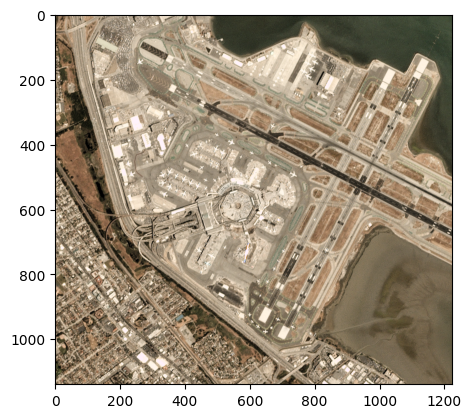

In [48]:
num_labelers = 10
initial_accuracy = {"airplane": 0.5} # only one class for demo
labelers = [Labeler(i, initial_accuracy=initial_accuracy.copy()) for i in range(num_labelers)]

image = np.asarray(Image.open("airport.png"))

plt.imshow(image)


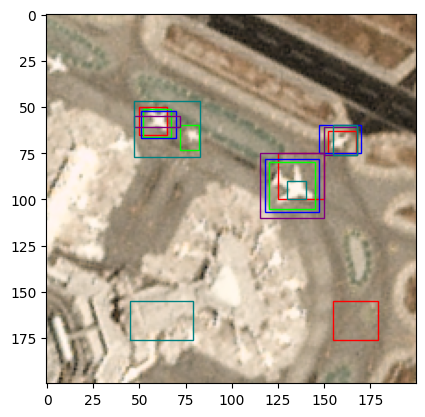

In [101]:
image = np.asarray(Image.open("airport.png").crop((600,400,800,600)))


# add labels
labels:Label = []
#---labeller 1
labels.append(Label(0, "airplane", labelers[0], [125,75,150,100]))
labels.append(Label(1, "airplane", labelers[0], [50,65,65,50]))
labels.append(Label(2, "airplane", labelers[0], [152,63,167,75]))
labels.append(Label(15, "airplane", labelers[0], [155,155,179,176]))
#---labeller 2
labels.append(Label(3, "airplane", labelers[1], [120,80,145,105]))
labels.append(Label(4, "airplane", labelers[1], [52,66,67,51]))
labels.append(Label(5, "airplane", labelers[1], [150,61,168,76]))
labels.append(Label(6, "airplane", labelers[1], [72,60,82,73]))
#---labeller 3
labels.append(Label(7, "airplane", labelers[2], [118,78,147,107]))
labels.append(Label(8, "airplane", labelers[2], [51,67,70,52]))
labels.append(Label(9, "airplane", labelers[2], [147,60,170,75]))
#---labeller 4
labels.append(Label(10, "airplane", labelers[3], [115,75,150,110]))
labels.append(Label(11, "airplane", labelers[3], [47,61,72,55]))
labels.append(Label(12, "airplane", labelers[3], [150,61,168,76]))
#--- labeller 5
labels.append(Label(13, "airplane", labelers[4], [130,90,140,100]))
labels.append(Label(14, "airplane", labelers[4], [47,47,83,77]))
labels.append(Label(15, "airplane", labelers[4], [155,60,168,76]))
labels.append(Label(15, "airplane", labelers[4], [45,155,79,176]))



# prepate bounding boxes to be added to image
bounding_boxes = []
# for identifying labeler responsible for label
colors = [[1,0,0],
          [0,1,0],
          [0,0,1],
          [0.5,0,0.5],
          [0,0.5,0.5]]
fig, ax = plt.subplots()
ax.imshow(image)

for label in labels:
    bounding_boxes.append(patches.Rectangle(label.coordinates[0:2], label.coordinates[2]-label.coordinates[0], label.coordinates[3]-label.coordinates[1], linewidth=1, edgecolor=colors[label.labeler.id], facecolor='none'))

for bounding_box in bounding_boxes:
    ax.add_patch(bounding_box)

plt.show()
